<a href="https://colab.research.google.com/github/atstuyuki/mediapipe_hand/blob/main/mediapipe_hand_create_regressionmodel_20221103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_formate ={'png', 'retina'}
import os
import sys
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#ファイルタブからCSVを作業ディレクトリにUpLoad
#CSVファイルをup_load

from google.colab import files
import os
uploaded = files.upload()
#uploadedは辞書型なのでファイル名を取り出し、絶対パスを取得してfullpathという変数を当てる
for k in uploaded.keys():
  print('file name:',k)
fullpath_csv=os.path.abspath(k)
print('fullpath:',fullpath_csv)

Saving summarized_data.csv to summarized_data.csv
file name: summarized_data.csv
fullpath: /content/summarized_data.csv


In [3]:
df=pd.read_csv(fullpath_csv,sep=',',encoding='UTF-8')#CSVをデータフレームに読み込む
df.head()

,Source.Name,time,mp_joint_angle,ip_joint_angle,tip_joint_angle,mp_distancelist,tip_distancelist,palmsize1,palmsize2,tureangle
0,result_1-30.mp4_20221101-111257.csv,0.000000,40.765482,27.264330,21.052803,0.539211,0.993037,0.501528,0.665052,20
1,result_1-30.mp4_20221101-111257.csv,0.078059,36.940052,25.049551,19.706817,0.492307,0.909949,0.555663,0.659249,20
2,result_1-30.mp4_20221101-111257.csv,0.142184,35.486838,23.769805,19.049301,0.477612,0.885435,0.571162,0.664895,20
3,result_1-30.mp4_20221101-111257.csv,0.201359,34.247720,23.162783,18.811908,0.468985,0.861992,0.569106,0.666683,20
4,result_1-30.mp4_20221101-111257.csv,0.259697,32.949765,22.376584,18.232054,0.456782,0.850724,0.583882,0.676863,20


In [4]:
#dfの型の確認　object型等は変更する必要がある
df.dtypes

Source.Name          object
time                float64
mp_joint_angle      float64
ip_joint_angle      float64
tip_joint_angle     float64
mp_distancelist     float64
tip_distancelist    float64
palmsize1           float64
palmsize2           float64
tureangle             int64
dtype: object

In [5]:
#今回の解析に不要な列をdrop 

df=df.drop(['Source.Name','time'],axis='columns') 

In [6]:
# データフレームの統計量記述
#min maxの外れ値をチェックして、外れ値があればもとのCSVデータをチェックしておく
df.describe()

,mp_joint_angle,ip_joint_angle,tip_joint_angle,mp_distancelist,tip_distancelist,palmsize1,palmsize2,tureangle
count,52268.000000,52268.000000,52268.000000,52268.000000,52268.000000,52268.000000,52268.000000,52268.000000
mean,39.987412,34.859297,34.824122,0.542578,1.173861,0.401073,0.695977,44.817670
std,7.587677,10.281126,13.189837,0.085032,0.305756,0.120305,0.131792,19.602475
min,27.231638,19.683492,16.594059,0.375031,0.761612,0.219583,0.315108,20.000000
25%,32.572197,23.887251,20.521321,0.465698,0.842918,0.317747,0.637789,20.000000
50%,40.045976,36.589923,37.230604,0.545375,1.169498,0.351509,0.717541,40.000000
75%,45.656398,43.524784,47.733261,0.609679,1.406796,0.413003,0.809057,60.000000
max,63.530061,59.518955,61.564619,0.833241,1.845026,0.637123,0.881377,80.000000


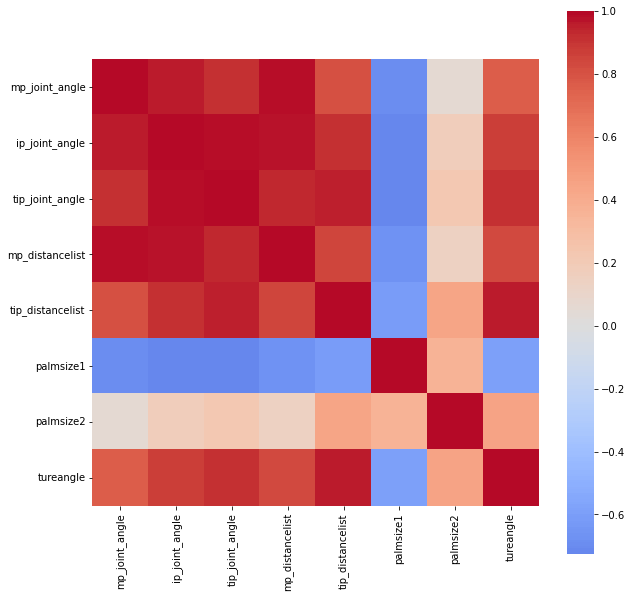

In [7]:
#dfでの相関係数のheatmap 白黒表示であればcmap='binary'とする
plt.figure(figsize=(10,10))
cmap=sns.color_palette('coolwarm',200)
sns.heatmap(df.corr(),square=True,annot=False,cmap=cmap,center=0)

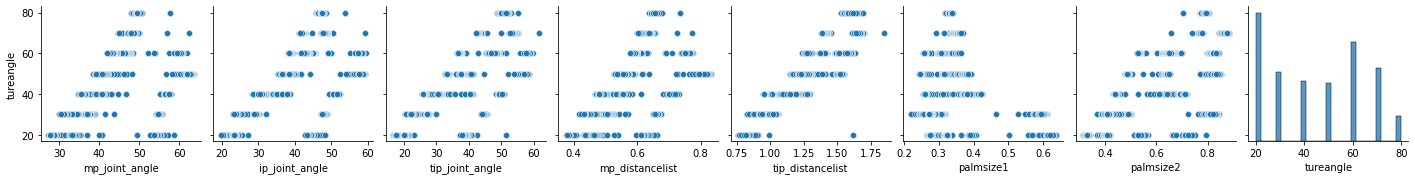

In [ ]:
#dataの可視化　探索的データ解析'EDA'
#pair plot を試す　X軸にすべての項目　ｙ軸に目的変数('trueangle')を設定
sns.pairplot(df, x_vars=df[0:],y_vars='tureangle')
plt.show()

In [8]:
#データセットの分割　正解クラス　説明変数の指定
#訓練データの不要な列を df.drop([],axis='columns')で指定 
train_x=df.drop(['tureangle'],axis='columns') 
train_y=df['tureangle']
(train_x,test_x,train_y,test_y)=train_test_split(train_x,train_y,test_size=0.1,random_state=0)

In [9]:
#データセットの形確認
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(47041, 7)
(5227, 7)
(47041,)
(5227,)


In [10]:
#train学習データ 教師データ(np.arrayの内容表示）
print(train_x)
print(train_y)

       mp_joint_angle  ip_joint_angle  tip_joint_angle  mp_distancelist  \
31352       48.131516       48.156763        53.300147         0.638185   
39828       54.714909       47.492026        44.180831         0.660996   
31677       36.844322       29.094966        27.320427         0.505880   
44254       32.362815       24.106665        20.508678         0.467343   
15821       44.102250       38.511331        37.004728         0.594010   
...               ...             ...              ...              ...   
21243       44.756454       38.848124        36.994146         0.602421   
45891       43.221541       42.733527        47.840854         0.600780   
42613       36.985518       29.123280        27.366012         0.507689   
43567       55.523404       48.380032        45.167145         0.671210   
2732        41.359603       29.115254        23.283433         0.544063   

       tip_distancelist  palmsize1  palmsize2  
31352          1.664937   0.357549   0.873590  
398

In [11]:
#linerRegression の学習
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
#特徴量の標準化
sc=StandardScaler()
x_train_std=sc.fit_transform(train_x)
x_test_std=sc.transform(test_x)
#特徴量がすべて角度であるときは標準化せず
#modelの定義
model=LinearRegression()
model.fit(x_train_std,train_y)

LinearRegression()

In [12]:
print('モデルの傾き:',model.coef_)
print('モデルの切片:',model.intercept_)

モデルの傾き: [ -5.63726902 -23.89458114  14.01609451  19.18863462   7.59247486
  -7.86960613   7.04450867]
モデルの切片: 44.83089220042092


In [13]:
#pickleを使ってモデルを保存
import pickle
file = 'mediapipe_hand_trained_liner_regression_model_20221102.pkl'
pickle.dump(model, open(file, 'wb'))


In [14]:
#pickleを使ってモデルを読み込み
model = pickle.load(open('mediapipe_hand_trained_liner_regression_model_20221102.pkl', 'rb'))
model

LinearRegression()

In [15]:
#RMSEではなくMean absolute percentage error(MAPE)を計算する関数の作成
#MAPE=平均絶対パーセント誤差
def calc_mape(y_true, y_pred):
  data_num = len(y_true)
  mape= (np.sum(np.abs(y_pred-y_true)/y_true)/data_num)*100
  return mape

train_pred =model.predict(x_train_std)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = model.predict(x_test_std)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 7.418%
test mape:7.398%


In [16]:
min=np.min(test_y)
max=np.max(test_y)
print(min)
print(max)

20
80


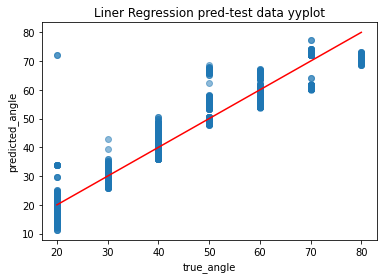

r2:0.950
相関係数:0.975


In [17]:
#x軸に実際の値　ｙ軸に予測値　角度min-maxの範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
#軸の最大値最小値を定義
min=np.min(test_y)
max=np.max(test_y)
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 100), np.linspace(min, max, 100), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('Liner Regression pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [19]:
#サポートベクトル回帰の訓練　パラメータによってはかなり時間がかかる
from sklearn.svm import SVR
model_SVR=SVR(kernel='linear', C=1, epsilon=0.1, gamma='auto')
model_SVR.fit(x_train_std,train_y)

SVR(C=1, gamma='auto', kernel='linear')

In [23]:
#pickleを使ってモデルを保存
import pickle
file = 'mediapipe_hand_trained_SVM_regression_model_20221103.pkl'
pickle.dump(model, open(file, 'wb'))

In [20]:
train_pred =model_SVR.predict(x_train_std)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = model_SVR.predict(x_test_std)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 6.270%
test mape:6.197%


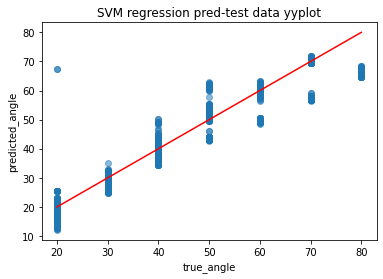

r2:0.935
相関係数:0.967


In [22]:
#x軸に実際の値　ｙ軸に予測値　プロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
#軸の最大値最小値を定義
min=np.min(test_y)
max=np.max(test_y)
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 100), np.linspace(min, max, 100), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('SVM regression pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [24]:
#Ridge回帰
# ライブラリーのインポート
from sklearn.linear_model import Ridge

# モデルの学習
ridge = Ridge(alpha=10)
ridge.fit(x_train_std, train_y)

Ridge(alpha=10)

In [25]:
#pickleを使ってモデルを保存
import pickle
file = 'mediapipe_hand_trained_Ridge_model_20221103.pkl'
pickle.dump(model, open(file, 'wb'))

In [26]:
train_pred =ridge.predict(x_train_std)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = ridge.predict(x_test_std)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 7.332%
test mape:7.316%


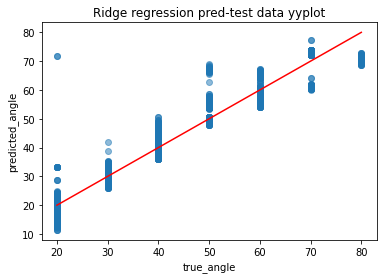

r2:0.950
相関係数:0.975


In [27]:
#x軸に実際の値　ｙ軸に予測値　プロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
#軸の最大値最小値を定義
min=np.min(test_y)
max=np.max(test_y)
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 100), np.linspace(min, max, 100), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('Ridge regression pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [28]:
#Lasso回帰
# ライブラリーのインポート
from sklearn.linear_model import Lasso

# モデルの学習
lasso = Lasso(alpha=0.05)
lasso.fit(x_train_std, train_y)

Lasso(alpha=0.05)

In [29]:
#pickleを使ってモデルを保存
import pickle
file = 'mediapipe_hand_trained_Lasso_model_20221103.pkl'
pickle.dump(model, open(file, 'wb'))

In [30]:
train_pred =lasso.predict(x_train_std)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = lasso.predict(x_test_std)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 7.011%
test mape:6.933%


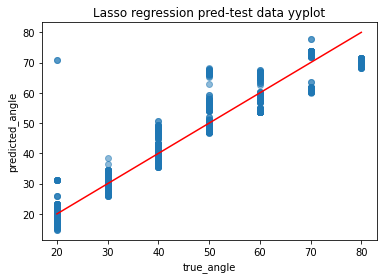

r2:0.948
相関係数:0.974


In [31]:
#x軸に実際の値　ｙ軸に予測値　プロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
#軸の最大値最小値を定義
min=np.min(test_y)
max=np.max(test_y)
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 100), np.linspace(min, max, 100), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('Lasso regression pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [32]:
# EkasticNet ライブラリーのインポート
from sklearn.linear_model import ElasticNet

# モデルの学習
elasticnet = ElasticNet(alpha=0.05)
elasticnet.fit(x_train_std,train_y)

ElasticNet(alpha=0.05)

In [33]:
#pickleを使ってモデルを保存
import pickle
file = 'mediapipe_hand_trained_ElsticNet_model_20221103.pkl'
pickle.dump(model, open(file, 'wb'))

In [35]:
train_pred =lasso.predict(x_train_std)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = lasso.predict(x_test_std)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 7.011%
test mape:6.933%


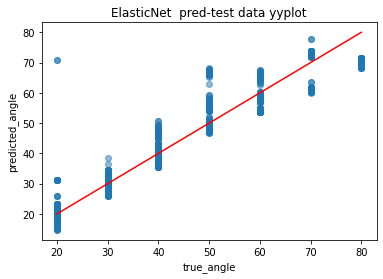

r2:0.948
相関係数:0.974


In [34]:
#x軸に実際の値　ｙ軸に予測値　プロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
#軸の最大値最小値を定義
min=np.min(test_y)
max=np.max(test_y)
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 100), np.linspace(min, max, 100), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('ElasticNet  pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [36]:
# RandomForest回帰　ライブラリーのインポート
from sklearn.ensemble import RandomForestRegressor

# モデルの学習
RF = RandomForestRegressor()
RF.fit(x_train_std, train_y)

RandomForestRegressor()

In [37]:
#pickleを使ってモデルを保存
import pickle
file = 'mediapipe_hand_trained_Rondomforest_model_20221103.pkl'
pickle.dump(model, open(file, 'wb'))

In [38]:
train_pred =lasso.predict(x_train_std)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = lasso.predict(x_test_std)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 7.011%
test mape:6.933%


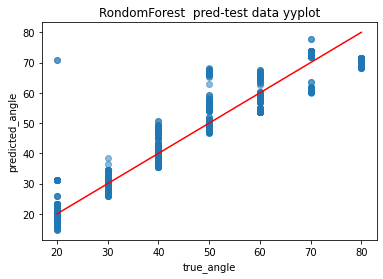

r2:0.948
相関係数:0.974


In [39]:
#x軸に実際の値　ｙ軸に予測値　プロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
#軸の最大値最小値を定義
min=np.min(test_y)
max=np.max(test_y)
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 100), np.linspace(min, max, 100), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('RondomForest  pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [ ]:
#LightGBMの学習
# train data からさらにvalidation dataを分ける
trn_x,val_x, trn_y, val_y = train_test_split(train_x, train_y,test_size=0.2, random_state=0 )
lgb_dataset_trn=lgb.Dataset(trn_x, label=trn_y, categorical_feature='auto')
lgb_dataset_val=lgb.Dataset(val_x, label= val_y, categorical_feature='auto')

params={
    'objective':'rmse',#‘metric’は、’mean_absolute_error’, ‘mean_squared_error’, ‘rmse’から選ぶ
    'larning_rate':0.1,
    'max_depth':3,
}

lgb_model=lgb.train(
    params=params,
    train_set=lgb_dataset_trn,
    valid_sets=[lgb_dataset_val],
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100

)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.04417
[200]	valid_0's rmse: 0.809419
[300]	valid_0's rmse: 0.726919
[400]	valid_0's rmse: 0.694298
[500]	valid_0's rmse: 0.675758
[600]	valid_0's rmse: 0.662129
[700]	valid_0's rmse: 0.656451
[800]	valid_0's rmse: 0.648529
[900]	valid_0's rmse: 0.64144
[1000]	valid_0's rmse: 0.637472
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.637472


#pickleをつかってモデルを保存

In [ ]:
import pickle
file = 'mediapipe_hand_trained_lightGBM_20221102_model.pkl'
pickle.dump(lgb_model, open(file, 'wb'))


#pickleを使ってモデルを読み出し

In [ ]:
lgb_model = pickle.load(open('mediapipe_hand_trained_lightGBM_20221102_model.pkl', 'rb'))
lgb_model

In [ ]:
#RMSEではなくMean absolute percentage error(MAPE)を計算する関数の作成
#MAPE=平均絶対パーセント誤差
def calc_mape(y_true, y_pred):
  data_num = len(y_true)
  mape= (np.sum(np.abs(y_pred-y_true)/y_true)/data_num)*100
  return mape

train_pred =lgb_model.predict(train_x)
train_mape =calc_mape(train_y.values, train_pred)

val_pred = lgb_model.predict(val_x)
val_mape = calc_mape(val_y.values, val_pred)

print(f'train mape: {train_mape:.3f}%')
print(f'valid mape:{val_mape: .3f}%')

train mape: 0.216%
valid mape: 0.193%


In [ ]:
#テストデータに対する評価
test_pred = lgb_model.predict(test_x)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

test mape:0.231%


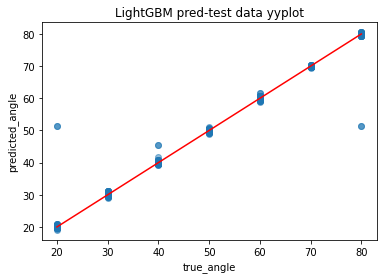

r2:0.998
相関係数:0.999


In [ ]:
#x軸に実際の値　ｙ軸に予測値　肩外転角度20-150の範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
min=np.min(test_y)
max=np.max(test_y)

plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 130), np.linspace(min, max, 130), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('LightGBM pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

#テストデータの真値と予測値をCSVに保存

In [ ]:
result=np.vstack((test_pred, test_y))
result=result.T

In [ ]:
np.savetxt('lightGBM_prediction_20221102.csv',result,delimiter = ',',fmt = '%s',header='prediction,true_value')

#LightGBMをoputunaにてハイパーパラメータチューニング

In [ ]:
#optunaのlightGBM用のAPIによるハイパーパラメーターチューニング
#まず ！pipでインストール
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 28.6 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 209 kB 74.0 MB/s 
     |████████████████████████████████| 78 kB 9.1 MB/s 
     |████████████████████████████████| 112 kB 97.6 MB/s 
     |████████████████████████████████| 147 kB 77.9 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=4478e4f4e0e471017a66895cbcdc1ce0c7b07fbebd350e21f89ab1a9500d952c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
import optuna.integration.lightgbm as lgbo

# 回帰の場合
opt_params = {
    "objective":"regression",
    "metric":"rmse"
}
#探索用にデータを作り直す
reg_train = lgb.Dataset(train_x,train_y,free_raw_data=False)
reg_eval = lgb.Dataset(test_x,test_y,free_raw_data=False)

#パラメータを探す
opt=lgbo.train(
    opt_params,
    reg_train,
    valid_sets = reg_eval,
    verbose_eval=False,
    #ラウンド数
    num_boost_round = 5,
    #打ち切り
    #early_stopping_rounds = 100
)

[I 2022-11-02 00:32:06,730] A new study created in memory with name: no-name-98a06bf4-ba61-4a2e-b2c3-164c0e9d6056
min_data_in_leaf, val_score: 11.502456: 100%|##########| 5/5 [00:00<00:00, 12.92it/s]


In [ ]:
#最適なパラメータを取得 optunaでのベストモデルがoptになっている
opt.params

{'objective': 'regression',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 2.463427206844718e-07,
 'lambda_l2': 1.0039390364155806e-08,
 'num_leaves': 46,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5}

In [ ]:
# 選んだパラメータで再度学習
opt_model = lgb.train(params=opt.params,
    train_set=reg_train,
    valid_sets=reg_eval,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100,)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.83028
[200]	valid_0's rmse: 0.830279
Early stopping, best iteration is:
[108]	valid_0's rmse: 0.830279


In [ ]:
#テストデータで予測して、予測値を算出
op_test_pred = opt_model.predict(test_x)
op_test_mape = calc_mape(test_y.values,op_test_pred)

print(f'Oputuna test mape:{op_test_mape:.3f}%')

Oputuna test mape:0.074%


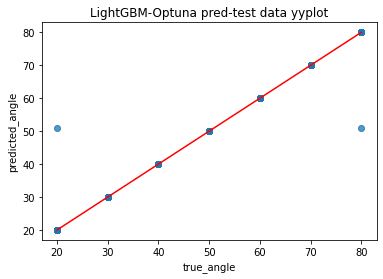

Oputuna test r2:0.998
Oputuna 相関係数:0.999


In [ ]:
#x軸に実際の値　ｙ軸に予測値をプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(test_y, op_test_pred, alpha = 0.5)
plt.plot(np.linspace(min, max, 130), np.linspace(min, max, 130), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('LightGBM-Optuna pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
op_r2= r2_score(test_y,op_test_pred)
print(f'Oputuna test r2:{op_r2:.3f}')
#相関係数の計算
op_cor = np.sqrt(op_r2)
print(f'Oputuna 相関係数:{op_cor:.3f}')

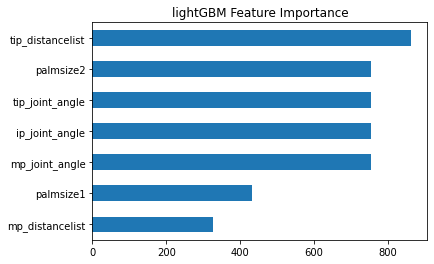

In [ ]:
# feature importanceの可視化1　デフォルトの設定
feat_imp = pd.Series(opt_model.feature_importance(), index=test_x.columns).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='lightGBM Feature Importance', color=sns.color_palette()[0])
plt.show()

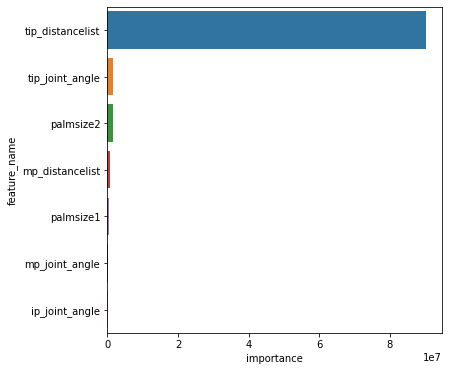

In [ ]:
#feature importanceの可視化2
feature_importance = pd.DataFrame({
    'feature_name': opt_model.feature_name(),
    'importance': opt_model.feature_importance(importance_type='gain'),#importance_typeが異なる今回はgainを採用
})
feature_importance = feature_importance.sort_values('importance', ascending = False)

plt.figure(figsize= (6,6))
sns.barplot(data = feature_importance, x ='importance', y='feature_name')
plt.savefig('feature_importance.png')

#pickleによるoputunaモデルの保存と読みだし

In [ ]:
#optunaでパラメータ調整したmodelの保存
import pickle
file = 'mediapipe_hand_trained_oputuna_lightGBM_20221102_model.pkl'
pickle.dump(opt_model, open(file, 'wb'))

In [ ]:
opt_model = pickle.load(open('mediapipe_hand_trained_oputuna_lightGBM_20221102_model.pkl', 'rb'))
opt_model

#作成したモデルの解釈性としてSHAPを使用してみる

In [ ]:
!pip install shap #shapをインストール

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 37.2 MB/s 


In [ ]:
#shapをインポートしてモデルのshap値を計算
import shap
lgb_explainer = shap.TreeExplainer(opt_model, train_x)
lgb_shap_values = lgb_explainer.shap_values(train_x)


 99%|===================| 46466/47041 [01:28<00:01]       

In [ ]:
# jupyter notebookにコードを表示させるためにjsをロード
shap.initjs()

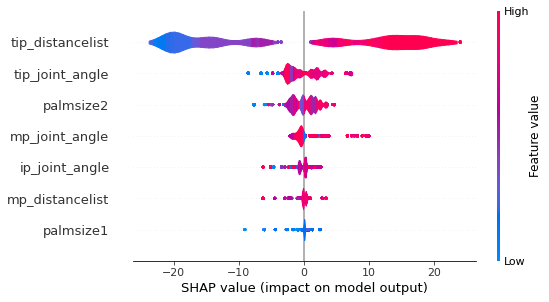

In [ ]:
# LightGBMでのViolin Plotの可視化
shap.summary_plot(lgb_shap_values, train_x, plot_type="violin")#ploty type 'dot' or 'violin'

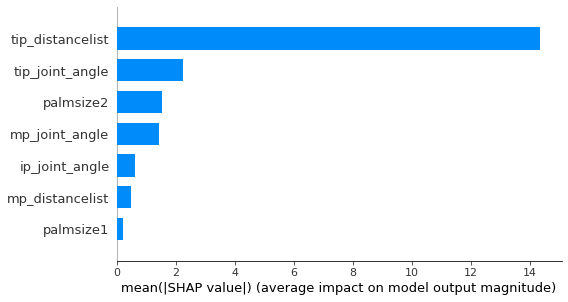

In [ ]:
shap.summary_plot(lgb_shap_values, train_x, plot_type="bar")

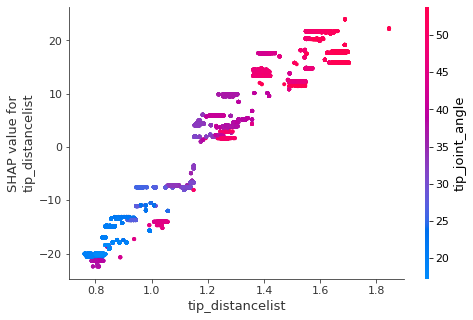

In [ ]:
# LightGBMでのPartial Dependence Plotの可視化
#shap.dependence_plot("rank(1)",interaction_index='BMI',lgb_shap_values, train_x)
shap.dependence_plot(ind='tip_distancelist',
                     interaction_index='tip_joint_angle',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

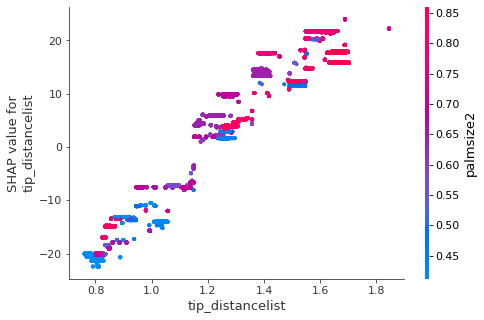

In [ ]:
# LightGBMでのPartial Dependence Plotの可視化
shap.dependence_plot(ind='tip_distancelist',
                     interaction_index='palmsize2',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

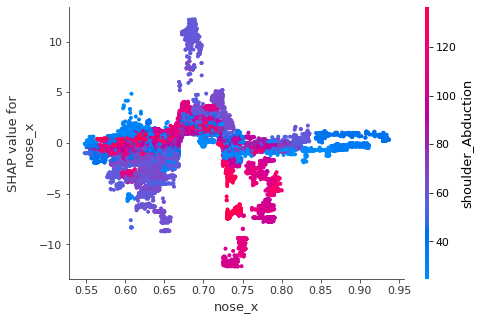

In [ ]:
# LightGBMでのPartial Dependence Plotの可視化
shap.dependence_plot(ind='nose_x',
                     interaction_index='shoulder_Abduction',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

In [ ]:
#Force plotによる可視化
#google colabでは動かなかった　ローカルなら動くかも
#20220703時点では動くが思いのでデータ数を減らすこと
"""shap.force_plot(base_value=lgb_explainer.expected_value,
                shap_values=lgb_shap_values,
                features=train_x,
                feature_names=train_x.columns)"""

'shap.force_plot(base_value=lgb_explainer.expected_value,\n                shap_values=lgb_shap_values,\n                features=train_x,\n                feature_names=train_x.columns)'

#XGBoostによる回帰モデルの作成

In [ ]:
#参考サイト　https://takaherox.hatenablog.com/entry/2020/07/06/234337
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

In [ ]:
# 固定パラメータの指定
SEED = 42
TEST_SIZE = 0.2
target = "class"
predictors = [i for i in df.columns if i not in target]

In [ ]:
## XGBoostモデル作成
params = {
    "objective" : "reg:squarederror",
    "eval_metric" : "rmse"
}

 # モデルの学習
xgb_train = xgb.DMatrix(train_x,train_y)
xgb_test = xgb.DMatrix(test_x, test_y)
evals_result = {}
xgb_model = xgb.train(
    params,
    xgb_train,
    num_boost_round=5000,  
    early_stopping_rounds=500,
    evals = [(xgb_test, 'eval'), (xgb_train, 'train')],
    evals_result=evals_result,
     verbose_eval=100
    
)             

[0]	eval-rmse:67.997	train-rmse:68.7258
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 500 rounds.
[100]	eval-rmse:3.34441	train-rmse:1.96412
[200]	eval-rmse:3.38583	train-rmse:1.50034
[300]	eval-rmse:3.43001	train-rmse:1.23717
[400]	eval-rmse:3.45755	train-rmse:1.09126
[500]	eval-rmse:3.49655	train-rmse:0.992947
[600]	eval-rmse:3.51508	train-rmse:0.934994
[700]	eval-rmse:3.51564	train-rmse:0.894454
[800]	eval-rmse:3.52056	train-rmse:0.8715
[900]	eval-rmse:3.53343	train-rmse:0.854351
[1000]	eval-rmse:3.53653	train-rmse:0.842116
[1100]	eval-rmse:3.54141	train-rmse:0.835062
[1200]	eval-rmse:3.54295	train-rmse:0.830413
[1300]	eval-rmse:3.54496	train-rmse:0.826712
[1400]	eval-rmse:3.54719	train-rmse:0.824656
[1500]	eval-rmse:3.54693	train-rmse:0.822919
[1600]	eval-rmse:3.54862	train-rmse:0.821729
[1700]	eval-rmse:3.54911	train-rmse:0.820965
[1800]	eval-rmse:3.54979	train-rmse:0.820384
[1900]	eval-rmse:3.

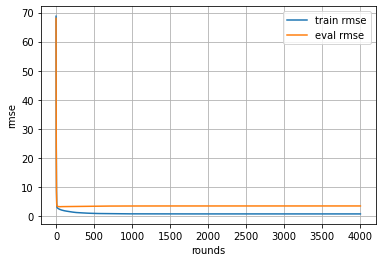

In [ ]:
#trainデータに対してのloss推移をplot
plt.plot(evals_result['train']['rmse'], label='train rmse')
#testデータに対してのloss推移をplot
plt.plot(evals_result['eval']['rmse'], label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.savefig("img.png", bbox_inches='tight')
plt.show()

In [ ]:
pred = xgb_model.predict(xgb_test)
print(pred)

[109.98924   19.759445  70.891655 159.89874  145.21472   79.38924
 140.67116   40.36644  149.97766   90.10979  146.05264   83.23608
  51.270065  20.049402  79.2887    39.62883  116.26281  130.04768
  19.905838  36.45769   99.00524    9.999999 101.89857   86.17849
 119.82354   92.25628   50.47161    9.966882  49.33235  141.78706
 115.942314  38.89595  159.99825   21.302307 141.1271    77.3431
 109.993935 160.00244   40.376022  40.669262  30.252861  60.05701
 139.66315  105.83369  128.66785  121.32644   40.28807   19.90623
 149.3542   110.665016 150.43407   90.482155 159.72588  160.13507
 140.78543   92.89387   39.94044  147.9626    77.31875   29.957655
 160.07288   79.949615 129.65211   70.50892   68.9448    64.91212
 111.26435  129.95964  159.99538   69.83723   30.898031  49.93419
  60.116646 146.98288  100.0066    90.514275 149.99547   39.933174
 143.22052   40.01464    9.999999  69.858574   9.999999  84.62211
  69.9604   141.07005  147.76445   83.505516  67.62879    9.999999
  70.446

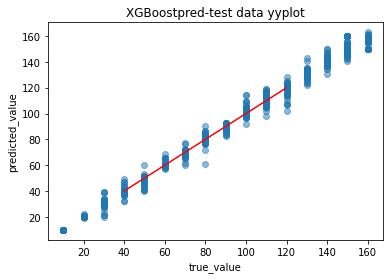

r2:0.994
相関係数:0.997
rmse:3.553


In [ ]:
#実測値と予測値のyyplot
plt.scatter(test_y, pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('XGBoostpred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')
#rmseの計算
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, pred)
rmse = np.sqrt(mse)
print(f'rmse:{rmse:.3f}')

In [ ]:
#optunaによるXGBoostのハイパーパラメーターチューニング
#参考文献の都合でscikitlearnAPI使用
from xgboost import XGBRegressor

In [ ]:
# optunaの目的関数を設定する
#gtreeのパラメーター設定です。
'''def objective(trial):
    eta =  trial.suggest_loguniform('eta', 1e-8, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
    max_delta_step = trial.suggest_loguniform('max_delta_step', 1e-8, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 1000.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1000.0)


    regr =xgb.XGBRegressor(eta = eta, gamma = gamma, max_depth = max_depth,
                           min_child_weight = min_child_weight, max_delta_step = max_delta_step,
                           subsample = subsample,reg_lambda = reg_lambda,reg_alpha = reg_alpha)

    score = cross_val_score(regr, train_x, train_y, cv=5, scoring="r2")
    r2_mean = score.mean()
    print(r2_mean)

    return r2_mean'''

def objective(trial):

    params = {
        "silent": 1,
        "max_depth": trial.suggest_int("max_depth", 6, 9),
        "min_child_weight": 1,
        "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
        "tree_method": "exact",
        "objective": "reg:linear",
        "eval_metric": "rmse",
        "predictor": "cpu_predictor"  
    }

    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=1000,
        seed=0,
        nfold=5, # CVの分割数
        metrics={"rmse"},
        early_stopping_rounds=5
    )

    return cv_results["test-rmse-mean"].min()

In [ ]:
# optunaで最適値を見つける
import optuna
from sklearn.model_selection import cross_val_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)



[I 2022-09-25 09:16:43,469] A new study created in memory with name: no-name-392d75db-27f6-4379-ad8b-238cc9b49a6c
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2022-09-25 09:16:44,174] Trial 0 finished with value: 3.4562682000000002 and parameters: {'max_depth': 8, 'eta': 0.49463936108492634}. Best is trial 0 with value: 3.4562682000000002.
[I 2022-09-25 09:16:45,031] Trial 1 finished with value: 3.4104244 and parameters: {'max_depth': 7, 'eta': 0.4002996391342526}. Best is trial 1 with value: 3.4104244.
[I 2022-09-25 09:16:45,575] Trial 2 finished with value: 3.621644 and parameters: {'max_depth': 9, 'eta': 0.7220980502770467}. Best is trial 1 with value: 3.4104244.
[I 2022-09-25 09:16:46,271] Trial 3 finished with value: 3.4073366 and parameters: {'max_depth': 7, 'eta': 0.46158485265065474}. Best is trial 3 with value: 3.40733

In [ ]:
# チューニングしたハイパーパラメーターをフィット モデル名をop_xgbとする
op_xgb = xgb.XGBRegressor(eta = study.best_params['eta'],#gamma = study.best_params['gamma'],
                                max_depth = study.best_params['max_depth'],##min_child_weight = study.best_params['min_child_weight'],
                                #max_delta_step = study.best_params['max_delta_step'],subsample = study.best_params['subsample'],
                                reg_lambda = study.best_params['reg_lambda'],reg_alpha = study.best_params['reg_alpha'])

op_xgb.fit(train_x,train_y)

KeyError: ignored

In [ ]:
#optunaによる最適化モデル(op_xgb)による予測
y_train_pred = op_xgb.predict(train_x)
y_test_pred = op_xgb.predict(test_x)

#評価指標の計算
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE   train: %.3f,  test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('RMSE  train: %.3f,  test: %.3f' %(
        np.sqrt(mean_squared_error(train_y, y_train_pred)),
        np.sqrt(mean_squared_error(test_y, y_test_pred))))
print('R^2   train: %.3f,  test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

In [ ]:
#実測値と予測値のyyplot
plt.scatter(test_y, y_test_pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('Optuna_XGBoostpred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,y_test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')
#rmseの計算
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_test_pred)
rmse = np.sqrt(mse)
print(f'rmse:{rmse:.3f}')

In [ ]:
# feature importanceの可視化

feat_imp = pd.Series(xgb_model.get_fscore()).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='XGBoost Feature Importance', color=sns.color_palette()[0])
plt.show()

In [ ]:
'''#Xgboost scikit learn APIによるgrid search 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

xgb_reg = xgb.XGBRegressor()

params=[{'max_depth':[3,4,5,6],
        'n_estimators':[100,300,500]
       }]

scorer=make_scorer(mean_squared_error, False)

grid_xgb_reg=GridSearchCV(xgb_reg,
                          param_grid=params,
                          scoring=scorer,
                          cv=5,
                          n_jobs=-1)

grid_xgb_reg.fit(train_x, train_y)

y_train_pred = grid_xgb_reg.predict(train_x)
y_test_pred = grid_xgb_reg.predict(test_x)

# 最良スコアとなるパラメータ値を出力
print(grid_xgb_reg.best_params_)'''

In [ ]:
#評価指標の計算
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE   train: %.3f,  test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('RMSE  train: %.3f,  test: %.3f' %(
        np.sqrt(mean_squared_error(train_y, y_train_pred)),
        np.sqrt(mean_squared_error(test_y, y_test_pred))))
print('R^2   train: %.3f,  test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

In [ ]:
#もう一度grid serachを実行
# 調整するハイパーパラメータの値の候補を設定
#この総当たり法は無限に時間がかかる
'''from xgboost import XGBRegressor
test_params = {'n_estimators':[100,200,300,400,500],
               'max_depth':[2,3,4,6,10],
    'min_child_weight':[1,2,3,4,6,10],
    'gamma':[0.0,0.1,0.2,2.0,10.0],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1.0],
    'reg_alpha':[100,1,0,.1,.01,.001,.0001],
    'reg_lambda':[100,1,0,.1,.01,.001,.0001],
    'learning_rate':[.1,.8,0.5,0.3,.01,.001,.0001]
}

# グリッドサーチCVの実行
gridsearch = GridSearchCV(estimator = XGBRegressor( seed=42),
                           param_grid = test_params, scoring='explained_variance',
                           cv = 5, return_train_score=False)

gridsearch.fit(train_x,train_y,n_jobs=-1, verbose=100,)'''

In [ ]:
gridsearch.best_params_
xgb_best= gridsearch.best_estimator_

In [ ]:
# XgboostのSHAP Valueの計算
xgb_explainer = shap.TreeExplainer(xgb_model)#オリジナルAPIもしくはscikit learn API のモデルを渡す
xgb_shap_values = xgb_explainer.shap_values(train_x)


In [ ]:
# XgboostでのViolin Plotの可視化
shap.summary_plot(xgb_shap_values,train_x,plot_type='violin')

In [ ]:
# XgboostでのPartial Dependence Plotの可視化
shap.dependence_plot("rank(1)", xgb_shap_values, train_x)